# Students: Lilach pardess & Assaf Taubenfeld

NOTE: we removed all the instractions to have the file more readable.



In [113]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
from collections import Counter, deque
from torch.utils.tensorboard import SummaryWriter
torch.manual_seed(42)

In [114]:
# Loading the shakespeare.txt file

f_name = 'shakespeare.txt' # if the file in different location, change this line
with open('shakespeare.txt', "r") as f:
    text = f.read()

print(f"Length of text: {len(text)} characters")
print(f"Number of unique characters: {len(set(text))}")
print(f"First 100 characters:\n{text[:100]}")

Length of text: 5436475 characters
Number of unique characters: 84
First 100 characters:
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as 


In [115]:
# Define CharacterTokenizer 

class CharacterTokenizer:
    def __init__(self, text):
        """
        Initialize tokenizer by building vocabulary from input text.
        
        Args:
            text: String containing all training text
        """
        # Get all unique characters and sort them
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        
        mapping_list = list(enumerate(self.chars))
        self.char_to_index = {char: index for index, char in mapping_list}
        self.index_to_char = {index: char for index, char in mapping_list}
 

    def encode(self, text):
        """Convert string to list of integers"""
        return [self.char_to_index[char] for char in text]
    
    def decode(self, indices):
        """Convert list of integers back to string"""
        return ''.join([self.index_to_char[index] for index in indices])
    
    def __len__(self):
        """Return the size of the vocabulary"""
        return self.vocab_size

# Assuming your text is loaded in a variable called 'text'
# Create the tokenizer
tokenizer = CharacterTokenizer(text)

# Test encoding and decoding
sample_text = "To be or not to be"
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)

print("Tokenizer vocab_size:", len(tokenizer))
print(f"Original: {sample_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")


Tokenizer vocab_size: 84
Original: To be or not to be
Encoded: [45, 70, 1, 57, 60, 1, 70, 73, 1, 69, 70, 75, 1, 75, 70, 1, 57, 60]
Decoded: To be or not to be


### Explanation [CharacterTokenizer]

Implementing characther based tokenizer.

init: create 2 maps, from char to index and from index to char. this will allow to encode and decode the characthers.



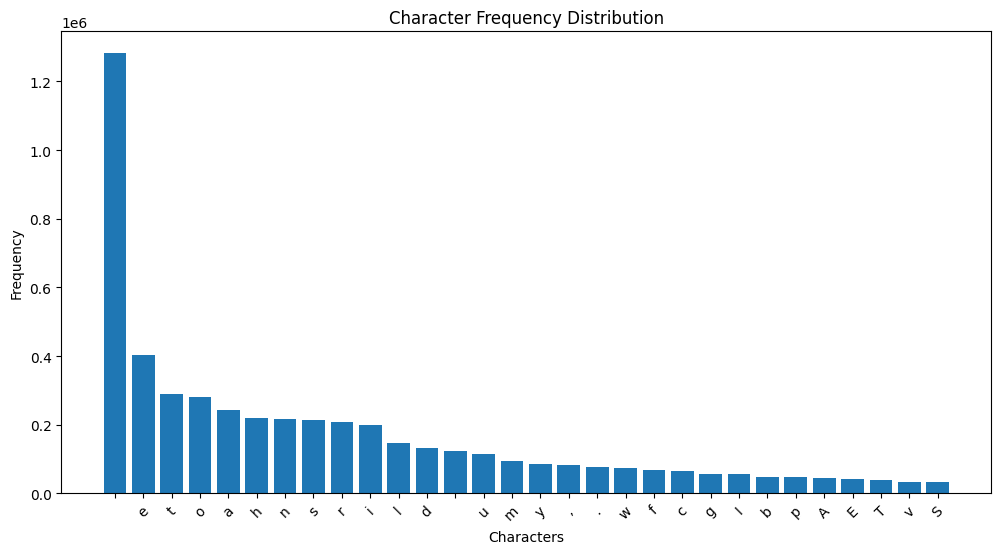

In [116]:
# plot the distribution of character frequencies
char_counts = Counter(text)
def plot_char_distribution(char_counts):
    """Plot the distribution of character frequencies."""
    chars, counts = zip(*char_counts.most_common(30))  # Get top 30 characters
    plt.figure(figsize=(12, 6))
    plt.bar(chars, counts)
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.title('Character Frequency Distribution')
    plt.xticks(rotation=45)
    plt.show()
plot_char_distribution(char_counts)




In [117]:
#Prepare dataset for training

# Convet the encoded text to torch tensor
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

print(f"Dataset shape: {data.shape}")

# Split into train and validation sets (90/10 split)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Training set size: {len(train_data):,} characters")
print(f"Validation set size: {len(val_data):,} characters")


Dataset shape: torch.Size([5436475])
Training set size: 4,892,827 characters
Validation set size: 543,648 characters


In [118]:
class ShakespeareDataset(Dataset):
    """
    PyTorch Dataset for Shakespeare text data.
    Generates overlapping sequences for language modeling.
    """
    
    def __init__(self, data, block_size):
        """
        Args:
            data: Tensor of encoded text tokens
            block_size: Length of each sequence (context length)
        """
        self.data = data
        self.block_size = block_size
        
        # Calculate number of possible sequences
        self.num_sequences = len(data) - block_size
        
        if self.num_sequences <= 0:
            raise ValueError(f"Data length ({len(data)}) must be greater than block_size ({block_size})")
    
    def __len__(self):
        """Return the number of possible sequences"""
        return self.num_sequences
    
    def __getitem__(self, idx):
        """
        Get a single sequence and its target.
        
        Args:
            idx: Index of the sequence start position
            
        Returns:
            tuple: (input_sequence, target_sequence)
        """
        # Extract input sequence of length block_size starting at idx
        input_sequence = self.data[idx:idx + self.block_size]
        
        # Extract target sequence (shifted by 1 position)
        target_sequence = self.data[idx + 1:idx + self.block_size + 1]
        
        return input_sequence, target_sequence

###  Explanation [ShakespeareDataset]: 

The getitem cant go out of bounds because how the dataloader of pytourch is implemented. the __len_ ensure that only valid idx will be provided to the getitem method. 

In [119]:
# Example datset class

num_workers = 2
shuffle_train = True
block_size = 128
batch_size = 16
train_dataset = ShakespeareDataset(train_data, block_size)
val_dataset = ShakespeareDataset(val_data, block_size)

print(f"Training sequences available: {len(train_dataset):,}")
print(f"Validation sequences available: {len(val_dataset):,}")
print("=" * 50)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle_train,
    num_workers=num_workers,
    drop_last=True  # Drop last incomplete batch for consistent batch sizes
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle validation data
    num_workers=num_workers,
    drop_last=False
)

x, y = next(iter(train_loader))
print("Example of a training batch instance:", end='\n\n')
print(f"Input:'{tokenizer.decode(x[0].tolist())}'") # Decode the first input sequence
print("=" * 50)
print(f"Target:'{tokenizer.decode(y[0].tolist())}'") # Decode the first target sequence

Training sequences available: 4,892,699
Validation sequences available: 543,520
Example of a training batch instance:

Input:'e, where doing tends to ill,
    The truth is then most done not doing it;
    The better act of purposes mistook
    Is to mist'
Target:', where doing tends to ill,
    The truth is then most done not doing it;
    The better act of purposes mistook
    Is to mista'


### MLP

Feed Forward Netroks. simple feed-forward component that process the output of the attention layer.
The MLp layer streach the dimention of the embedding from `embed_size` to `4*embed_size` and then back to `embed_size`.

In [120]:
class Mlp(nn.Module):
    """
    A simple MLP with two linear layers and GELU activation.
    First layer: embed_size -> 4 * embed_size
    Second layer: 4 * embed_size -> embed_size
    GELU activation between the two layers
    """
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.embed_size = config.embed_size
        self.layer_one = nn.Linear(self.embed_size, 4 * self.embed_size)
        self.layer_two = nn.Linear(4 * self.embed_size, self.embed_size)
        self.gelu = nn.GELU()
        
    def forward(self, x):
        x = self.layer_one(x)
        x = self.gelu(x)
        x = self.layer_two(x)
        return x

### Multi Head Masked Self-Attention Implementation

The self-attention mechanism which is the core of the transformer architecture, allowing the model to weigh the importance of different words in a sequence relative to each other. This guide walks you through completing the provided implementation.


In [121]:
import math

class SelfAttentionBlock(nn.Module):
    def __init__(self, config):
        super(SelfAttentionBlock, self).__init__()
        assert config.embed_size % config.num_heads == 0
        
        # self-attention values (key, query, value). pay attention that head_size * num_heads must be equal to embed_size
        self.c_atten = nn.Linear(config.embed_size, 3*config.embed_size) # multiply by 3 to get k, q, v
        
        # output projection
        self.c_proj = nn.Linear(config.embed_size, config.embed_size)
        
        self.embed_size = config.embed_size
        self.num_heads = config.num_heads

        mask = torch.tril(torch.ones(config.block_size, config.block_size)) # Lower triangular mask for causal attention
        mask = mask.view(1, 1, config.block_size, config.block_size) # B, 1, T, T
        self.register_buffer('mask', mask)  # register_buffer allows the mask to be part of the model state but not a parameter to optimize
        
    def forward(self, x):
        #  after each line print the shape of x
        """        Forward pass for the self-attention block.
        Args:
            x: Input tensor of shape (B, T, C) where B is batch size, T is sequence length, C is embedding size
        Returns:
            out: Output tensor of shape (B, T, C) after self-attention and projection
        """
        B, T, C = x.shape # Batch, sequence length, embed_size
        if C != self.embed_size:
            raise ValueError(f"Input embedding size {C} does not match expected embedding size {self.embed_size}")
        
        k, q, v = self.c_atten(x).split(self.embed_size, dim=2) # split the output into k, q, v.  Each is of shape (B, T, embed_size)
        head_size = self.embed_size // self.num_heads

        # reshape k, q, v to (B, T, num_heads, head_size). As embed_size == num_heads * head_size, we can do this by dividing embed_size by num_heads
        k = k.view(B, T, self.num_heads, head_size)
        q = q.view(B, T, self.num_heads, head_size)
        v = v.view(B, T, self.num_heads, head_size)

        # transpose k, q, v to (B, num_heads, T, head_size) 
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        # compute attention scores
        att_scores = (q @ k.transpose(-2, -1))
        att_scores = att_scores / math.sqrt(head_size) # scale the attention scores
        att_scores = att_scores.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf')) # mask the attention scores
        
        # calculte the attention weights
        att_weights = F.softmax(att_scores, dim=-1) # shape (B, num_heads, T, T)

        # compute the output
        output = att_weights @ v # shape (B, num_heads, T, head_size)

        # concatenate the output of the heads
        concatenated_output = output.transpose(1, 2).contiguous().view(B, T, C) # shape (B, T, C)

        # project the output to the embed_size
        final_output = self.c_proj(concatenated_output)

        return final_output # shape (B, T, embed_size)




### Transformer Block

The transformer block is a single layer containing two main components: **Multi-Head Attention** followed by **MLP (Multi-Layer Perceptron)**. This layer design gets stacked multiple times to create the full transformer.

In [122]:
class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.ln1 = nn.LayerNorm(config.embed_size)
        self.ln2 = nn.LayerNorm(config.embed_size)
        self.mlp = Mlp(config)
        self.self_attn = SelfAttentionBlock(config)
        
    def forward(self, x):
        normalized_attn_input = self.ln1(x)
        attn_output = self.self_attn(normalized_attn_input)
        x = x + attn_output
        normalized_mlp_input = self.ln2(x)
        mlp_output = self.mlp(normalized_mlp_input)
        x = x + mlp_output
        return x
    

## Transformer Model


The `GPT2` class represents the complete transformer model - a decoder-only architecture that processes text and predicts the next token. This is the full model that combines all the components you've built.

### Model Architecture Overview

**Embedding Layers**: Convert discrete tokens into continuous vector representations that the neural network can process.

**Transformer Stack**: Multiple transformer blocks stacked together, each refining the representations further.

**Output Layer**: Converts the final representations back to vocabulary predictions for next-token generation.

### Core Components

**Token Embedding (`wte`)**: Maps each vocabulary word to a learned vector representation. Transforms token IDs into dense embeddings of size `embed_size`.

**Position Embedding (`wpe`)**: Adds positional information since attention doesn't inherently understand word order. Each position gets its own learned embedding.

**Transformer Blocks**: Stack of identical blocks (typically 12-48 layers) that progressively refine the representations through attention and feed-forward processing.

**Final Layer Norm (`ln_f`)**: Normalizes the output from all transformer blocks before making predictions.

**Language Model Head (`lm_head`)**: Linear layer that converts final embeddings back to vocabulary logits for next-token prediction.

### Forward Pass Flow

**Input Processing**:
1. Convert token IDs to embeddings
2. Add positional embeddings to provide sequence order information
3. Combine token and position embeddings element-wise

**Transformer Processing**:
- Pass through each transformer block sequentially
- Each block applies attention and MLP with residual connections
- Representations become increasingly sophisticated through the stack

**Output Generation**:
1. Apply final normalization to stabilize outputs
2. Project to vocabulary size using the language model head
3. Compute loss against targets if provided for training

### Key Design Decisions

**Weight Sharing**: The token embedding and output projection share the same weights, reducing parameters and creating symmetry between input and output representations.

**Autoregressive Training**: During training, the model predicts each position based only on previous positions, learning the sequential nature of language.

**Next-Token Prediction**: The fundamental task is predicting the probability distribution over the vocabulary for what token should come next at each position.

This architecture enables the model to generate coherent text by learning statistical patterns in language through the simple but powerful objective of next-token prediction.

In [123]:
class GPT2(nn.Module):
    def __init__(self, config):
        super(GPT2, self).__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.embed_size), # token embeddings
            wpe = nn.Embedding(config.block_size, config.embed_size), # positional embeddings
            blocks = nn.ModuleList([Block(config) for _ in range(config.num_layers)]), # transformer blocks
            ln_f = nn.LayerNorm(config.embed_size)
            )
        )
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size) # output layer for next token prediction

        # sharing weights between token embedding and output layer
        self.transformer.wte.weight = self.lm_head.weight # this allows the model to use the same embeddings for input and output tokens
        
    def forward(self, idx, target=None):
        """ Forward pass of the GPT-2 model.
        Args:            idx: Input tensor of shape (B, T) where B is batch size and T is sequence length
            target: Optional target tensor of shape (B, T) for computing loss
        Returns:            logits: Output tensor of shape (B, T, vocab_size) containing logits for next token
            loss: Optional scalar loss value if target is provided
        """
        B, T = idx.shape
        assert T <= self.config.block_size, f"Input tokens length {T} exceeds maximum length {self.config.block_size}"
        
        token_embeddings = self.transformer.wte(idx)
        position_embeddings = self.transformer.wpe(torch.arange(T, device=idx.device))
        x = token_embeddings + position_embeddings
        for block in self.transformer.blocks:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        if target is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target.view(-1))
        else:
            loss = None
    
        return logits, loss

    def save_model(self, path):
        torch.save(self.state_dict(), path)
    
    def load_model(self, path):
        self.load_state_dict(torch.load(path))
            

### Text Generation using Top-K sampling


In [124]:
def top_k_sample(logits, k=50):
    values, indices = torch.topk(logits, k)
    probs = torch.softmax(values, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return indices[next_token]

def pipeline(model, tokenizer, k=10):
    """    Create a text generation pipeline for the given model and tokenizer.
    Args:
        model: The trained model instance
        tokenizer: The tokenizer instance
        k: Number of top-k tokens to sample from at each step (default: 10)
    Returns:A function that takes a prompt and generates text"""
    # step-by-step explanation of the pipeline function:
    """
    1. Set the model to evaluation mode
    2. Encode the input prompt using the tokenizer
    3. Convert the encoded prompt to a tensor and move it to the model's device
    4. While the length of the generated sequence is less than max_len:
        a. Get the model's logits for the last token in the sequence
        b. Extract the logits for the last token and apply softmax to get probabilities
        v. Use top-k sampling to select the next token based on probabilities
        d. Append the selected token to the sequence
    5. Decode the generated sequence back to text using the tokenizer
    6. Return the generated text
    """
    def generate(prompt, max_len=1024):

        model.eval()
        device = next(model.parameters()).device 
        encoded_prompt = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
        encoded_prompt = encoded_prompt.unsqueeze(0)

        for _ in range(max_len):
            with torch.no_grad():
                logits, _ = model(encoded_prompt)
                next_token_logits = logits[0, -1, :]
                next_token = top_k_sample(next_token_logits, k=10)

                # Update the squence with the new token
                encoded_prompt = torch.cat([encoded_prompt, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        
        return tokenizer.decode(encoded_prompt[0].tolist())


# exmple usage of the pipeline
"""
generate_text = pipeline(model, tokenizer)
prompt = "To be or not to be, that is the question: "
generated_text = generate_text(prompt, max_len=100)
"""


'\ngenerate_text = pipeline(model, tokenizer)\nprompt = "To be or not to be, that is the question: "\ngenerated_text = generate_text(prompt, max_len=100)\n'

### Conig the Transformer Model

In [125]:
# This is the most minmal config class for GPT-2 (Takes 40-60 to train). You are welcome to modify it to a bigger model or for loger but no the other way around (expet of batch size which you can reduce if you run out of memory)
class GPT2Config:
    def __init__(self):
        self.embed_size = 64
        self.num_heads = 2
        self.num_layers = 4
        self.vocab_size = len(tokenizer)
        self.block_size = 256
        self.lr = 3e-4
        self.batch_size = 32 # use a smaller batch size if you run out of memory
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.path = 'models/model.pth'
        self.num_epochs = 10

        self.patience = 5  # Early stopping patience
        self.grad_clip = 1.0  # Gradient clipping threshold
        
        # Learning rate scheduler configs
        self.use_scheduler = True
        self.scheduler_type = 'reduce_on_plateau'  # 'reduce_on_plateau', 'cosine', 'step'
        self.lr_patience = 2  # For ReduceLROnPlateau
        self.lr_factor = 0.5  # For ReduceLROnPlateau
        self.step_size = 1  # For StepLR
        self.gamma = 0.1  # For StepLR

## Traninig

In [126]:
# traning function
def train_model(model, train_loader, val_loader, optimizer, config=None):

    # Setup
    model.train()
    summary_writer = SummaryWriter(log_dir='runs/shakespeare_experiment')
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Training state tracking
    best_val_loss = float('inf')
    patience_counter = 0
    patience = getattr(config, 'patience', 5)  # Early stopping patience
    
    # Loss tracking
    train_losses = deque(maxlen=1000)
    global_step = 0
    
    print("Starting training...")
    print(f"Training for {config.num_epochs} epochs")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
    
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
        
        # Training phase
        model.train()
        epoch_train_losses = []
        
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}") as pbar:
            for batch_idx, (x, y) in enumerate(pbar):
                x, y = x.to(config.device), y.to(config.device)
                
                # Forward pass
                optimizer.zero_grad()
                logits, loss = model(x, y)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping (optional but recommended)
                if hasattr(config, 'grad_clip') and config.grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
                
                optimizer.step()
                
                # Track losses
                loss_item = loss.item()
                train_losses.append(loss_item)
                epoch_train_losses.append(loss_item)
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f"{loss_item:.4f}",
                    'avg_loss': f"{np.mean(train_losses):.4f}",
                    'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
                })
                
                # Log to tensorboard every N steps
                if global_step % 10 == 0:  # Log every 10 steps
                    summary_writer.add_scalar('Loss/train_step', loss_item, global_step)
                    summary_writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], global_step)
                
                global_step += 1
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=False) as val_pbar:
                for x, y in val_loader:
                    x, y = x.to(config.device), y.to(config.device)
                    logits, loss = model(x, y)
                    val_losses.append(loss.item())
                    val_pbar.set_postfix({'val_loss': f"{loss.item():.4f}"})
        
        # Calculate epoch metrics
        avg_train_loss = np.mean(epoch_train_losses)
        avg_val_loss = np.mean(val_losses)
        
        # Log epoch metrics
        summary_writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
        summary_writer.add_scalar('Loss/validation_epoch', avg_val_loss, epoch)
        
        print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        
        # Model checkpointing
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'global_step': global_step
        }
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(checkpoint, os.path.join('models', 'best_model.pt'))
            print(f"New best model saved! Val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
        
        # Save regular checkpoint
        torch.save(checkpoint, os.path.join('models', f'checkpoint_epoch_{epoch}.pt'))
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement")
            break
        
        # Save latest model using your custom save method
        if hasattr(model, 'save_model'):
            model.save_model(config.path)
    
    # Final logging
    summary_writer.close()
    print("Training complete!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return {
        'best_val_loss': best_val_loss,
        'final_train_loss': avg_train_loss,
        'final_val_loss': avg_val_loss,
        'epochs_trained': epoch + 1
    }

def estimate_loss(model, eval_iters, data_loaders={}):
    """        Estimate the loss of the model on the given splits.
    Args:
        model: The model to evaluate
        eval_iters: Number of iterations to average the loss over
        splits: List of dataset splits to evaluate (e.g., 'train', 'validation')
        data_loader: DataLoader instance for fetching batches
    Returns:
        out: Dictionary with average loss for each split
    """
    with torch.no_grad():
        out = {}
        model.eval()
        for split, dl in data_loaders.items():
            losses = 0
            for i in range(eval_iters):
                x, y = next(iter(dl))
                x, y = x.to(model.config.device), y.to(model.config.device)
                _, loss = model(x, y)
                losses += loss.item()
            out[split] = losses / eval_iters
        model.train()
    return out

In [127]:
# init config and datasets
con = GPT2Config()
train_dataset = ShakespeareDataset(train_data, con.block_size)
val_dataset = ShakespeareDataset(val_data, con.block_size)
train_loader = DataLoader(
    train_dataset,
    batch_size=con.batch_size,
    shuffle=shuffle_train,
    num_workers=4,
    drop_last=True  # Drop last incomplete batch for consistent batch sizes
)

val_loader = DataLoader(
    val_dataset,
    batch_size=con.batch_size,
    shuffle=False,  # Don't shuffle validation data
    num_workers=4,
    drop_last=False
)


model = GPT2(con)
model.to(con.device)
print(f"device: {con.device}")
optimizer = torch.optim.Adam(model.parameters(), lr=con.lr)

total_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
print(f"Total parameters: {total_params:,}")

device: cuda
Total parameters: 221,908


In [107]:
# Creating an optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=con.lr, weight_decay=0.01)

# train the model
results = train_model(model, train_loader, val_loader, optimizer, con)

Starting training...
Training for 10 epochs
Training batches: 152892, Validation batches: 16981

Epoch 1/10


Training Epoch 1:   7%|▋         | 10749/152892 [02:51<38:21, 61.77it/s, loss=1.8524, avg_loss=1.8731, lr=3.00e-04]

In [79]:
print(f"Model device: {next(model.parameters()).device}")
print(f"Training data device: {next(iter(train_loader))[0].device}")
print(f"CUDA available: {torch.cuda.is_available()}")

Model device: cuda:0
Training data device: cpu
CUDA available: True


In [73]:
print(f"config.device: {con.device}")  # Should print 'cuda'

config.device: cuda


In [ ]:
generator = pipeline(model, tokenizer, k=10)
print(generator('to be or not to be', max_len=1024)[0])